In [1]:
import sys
sys.path.append('../src/')

from decision_engine import MinimalSupplierSelectionModel, SupplierSelectionModel
from utils import generate_supplier_selector_variables, compute_reduced_price

---

# Decision Engine

### Background

- **What is Decision Engine?**: a tool to solve supplier selection problems
- **What is a supplier selection problem?**: Supplier selection is the process by which companies identify, evaluate, and award contracts to suppliers
- **High-level problem statement**: Select suppliers, subject to some constraints, so that an objective is minimised or maximised (e.g. minimise total cost)

### Aims

- Breakdown the supplier selection problem to its simplest form and then gently build up to a real problem in a way that promotes understanding. 
- Understand the general structure of the supplier selection problem (combinatorial optimisation problem)
- After studying this notebook, you should be able to identify structurally similar problems when talking to potential clients
- Detail an example where real quantifiable value has been delivered to a customer


### Who is this notebook aimed at?

- Everyone (with a focus on those who directly speak to potential customers)
- There is no maths: only a problem statement and the solution

---

# Typical problem statement

- Rolls-Royce need to procure approximately 1000 unique forged metal parts for the Trent XWB engine.
- There are 30 suppliers globally that have the skills and equipment to manufacture the required parts.
- Rolls-Royce provide all 30 suppliers with the information required to price and submit a bid to manufacture any unique part.
- Rolls-Royce receive the bids and must then decide who is awarded the manufacturing contract for every unique part

### Constraints

- At first this might appear to be trivial (select the cheapest bid for every part), however there are a number of constraints that must be considered
    - There is a limit on the number of unique parts that a supplier can manufacture
    - Manufacturers based in certain countries (e.g. China) are limited to manufacturing a percentage of the total demand (number of required units) of a unique part
    
### Combinatorial optimisation

- The problem is no longer trivial and is an example of a combinatorial optimisation problem 
- A combinatorial optimisation problem is the act of trying to find out the value (combination) of variables that optimises an index (value) from among many options under various constraints.
- The problem can be solved using constraint programming (CP) techniques

---

# Minimal problem

The supplier selection problem reduced to its most basic form

### Demand

A buyer is tasked with sourcing four parts for the manufacturing of a jet
engine. The demand for each part is defined by the below table.

| Part 1 | Part 2 | Part 3 | Part 4 |
| ------ | ------ | ------ | ------ |
| 300 | 20 | 150 | 80 |

### Price

There are two suppliers from which the buyer can source the required parts. The price quoted by each supplier for every part is detailed in the following table.

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | £60k | £605k | £9.5k | £75k |
| 2 | £50k | £615k | £9.8k | £60k |

### Manufacturing capacity

Each supplier has constraints on manufacturing - i.e. they only have the capacity (or are only trusted) to manufacture $x$ unique parts. The manufacturing capacity of both suppliers is specified below.

| Supplier | Unique parts limit | 
| -------- | ----------- |
| 1 | 2 |
| 2 | 3 |

### Objective and constraints

The **objective** is to minimise the total cost of procuring parts subject to the following constraints:

- Constraint 1 - a supplier cannot be assigned more unique parts than that defined by their manufacturing capacity
- Constraint 2 - the total number of units ordered (assigned to suppliers for manufacturing) must be equal to demand

## Solution

The buyer must procure parts from suppliers so that the total cost is minimised. The optimal solution (i.e. the solution that minimises cost) is detailed below.

In [2]:
price = [[60E3, 605E3, 9.5E3, 75E3],
         [50E3, 615E3, 9.8E3, 60E3]]

demand = [300, 20, 150, 80]

capacity = [2, 3]

supplier_selection_min_a = MinimalSupplierSelectionModel(price, demand, capacity)

In [3]:
supplier_selection_min_a.minimise_cost()


Optimal solution found: cost - £33,325,000.00

Supplier 1
----------
Part 1 units: 0
Part 2 units: 20
Part 3 units: 150
Part 4 units: 0

Supplier 2
----------
Part 1 units: 300
Part 2 units: 0
Part 3 units: 0
Part 4 units: 80



## Adding further constraints - maximum share

The buyer might have to consider an additional constraint on the maximum share of a unique part that can be assigned to a supplier. For example, manufacturers in China are limited to manufacturing 30% of the total demand of specific parts

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 100% | 100% | 30% | 100% |
| 2 | 80% | 100% |70% | 100% |

## Solution

Solving the same problem but with constraints on the maximum share, the cost rises from **£33,325,000** to **£36,556,200** - a 10% increase in the total cost

In [4]:
price = [[60E3, 605E3, 9.5E3, 75E3],
         [50E3, 615E3, 9.8E3, 60E3]]

demand = [300, 20, 150, 80]

capacity = [2, 3]

share = [[100, 100, 30, 100],
         [80, 100, 70, 100]]

supplier_selection_min_b = MinimalSupplierSelectionModel(price, demand, capacity, share)

In [5]:
supplier_selection_min_b.minimise_cost()


Optimal solution found: cost - £36,556,200.00

Supplier 1
----------
Part 1 units: 300
Part 2 units: 0
Part 3 units: 46
Part 4 units: 0

Supplier 2
----------
Part 1 units: 0
Part 2 units: 20
Part 3 units: 104
Part 4 units: 80


### Units (volume) - without maximum share constraint

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 0 | 20 | 150 | 0 |
| 2 | 300 | 0 | 0 | 80 |

### Units (volume) - with maximum share constraint

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 300 | 0 | 46 | 0 |
| 2 | 0 | 20 | 104 | 80 |

### What makes this problem difficult?

- Every cell in the above table can take a value from 0 to 300
- Using a naive brute force method, we would have to compute $300^8$ possible combinations and then select the best solution
- To put this in perspective, $300^8$ is $\approx 6.6\times10^{19}$ which is approaching the number of grains of sand on all the worlds beaches
- This problem is computationally intractable if we employ a brute force method
- By accounting for the constraints, the potential solution space can be significantly reduced and the problem becomes computationally feasible
- All of this complexity is handled by Google OR-Tools

---

# Going beyond the minimal problem - adding a time dimension

- The price of parts is a function of time and changes year to year 
- The price of parts will increase over time due to inflationary effects
- Conversely the price might decrease due to learning effects. This is where the cost of production per unit decreases over time as suppliers become more familiar with the production process, hence leading to improvements in their efficiency level
- The buyer might wish to switch the supplier of a part as time progresses but there will also be an associated transfer cost.

### Price

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [£60k, £62k, £64k] | [£605k, £610k, £605k] | [£9.5k, £9.6k, £9.7k] | [£75k, £75k, £75k] |
| 2 | [£50k, £55k, £60k] | [£615k, £610k, £605k] | [£9.8k, £9.7k, £9.6k] | [£60k, £70k, £80k] |

### Demand

| Part 1 | Part 2 | Part 3 | Part 4 |
| ------ | ------ | ------ | ------ |
| [300, 310, 320] | [20, 30, 40] | [150, 145, 130] | [80, 80, 80] |

### Manufacturing capacity

| Supplier | Parts limit | 
| -------- | ----------- |
| 1 | [3, 3, 3] |
| 2 | [4, 4, 4] |

### Maximum Share

The maximum share of a part that can be assigned to a supplier - e.g. manufactures based in China can only be assigned 30% of volume for an individual part

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 100 | 100 | 30 | 100 |
| 2 | 80 | 100 | 70 | 100 |


## Additional constraints

There are a number of additional constraints that we must consider:

- **Global transfer limit** - in a given year the total number of transfers (switching the manufacturing of a part to a new supplier) must be equal to or less than the global transfer limit. This help to maintain the robustness of the supply chain.
- **Supplier transer limit** - in a given year the total number of transfers that a supplier can accept must be less than the supplier transfer limit. This helps to maintain the robustness of the supply chain.
- **Minimum units (volume)** - a supplier will only accept a contract to manufacture a part if the number of units exceeds a minimum threshold
- **Trust** - Rolls-Royce buyers assign a trust value to every supplier and part. Trust is an uncertain metric that represents confidence in a supplier and is based on the historical performance of a supplier. In the simplest case, trust is a boolean variable: `True` - Rolls-Royce trust Supplier $x$ to manufacture Part $y$, `False` - Rolls-Royce do not trust Supplier $x$ to manufacture Part $y$.
- **Contractual requirements** - for example, a supplier must provide a specific quantity of a part in a given year


### Transfer limits

$$\textrm{global transfer limit per year} = 2$$

| Supplier | Transfer limit | 
| -------- | ----------- |
| 1 | 2 |
| 2 | 1 |

### Transfer costs

One off cost associated with retooling a factory so that a new part can be produced (note: not implemented in this example)

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [£0, £0, £0] | [£1000k, £1100k, £1200k] | [£0, 0, 0] | [£700k, £750k, £800k] |
| 2 | [£600k, £650k, £700k] | [£0, 0, 0] | [£0, 0, 0] | [£800k, £900k, £1000k] |

### Minimum units (volume)

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [100, 100, 100] | [5, 5, 5] | [20, 25, 30] | [15, 15, 15] |
| 2 | [100, 100, 100] | [5, 5, 5] | [20, 25, 30] | [15, 15, 15] |

### Trust

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | True | False | True | True |
| 2 | True | True | True | False |


In [6]:
price = [[[60E3, 62E3, 64E3], [605E3, 610E3, 615E3], [9.5E3, 9.6E3, 9.7E3], [75E3, 75E3, 75E3]],
         [[50E3, 55E3, 60E3], [615E3, 610E3, 605E3], [9.8E3, 9.7E3, 9.6E3], [60E3, 70E3, 80E3]]]

demand = [[300, 310, 320], [20, 30, 40], [150, 145, 130], [80, 80, 80]]

capacity = [[3, 3, 3], [4, 4, 4]]

share = [[100, 100, 30, 100],
         [80, 100, 70, 100]]

supplier_transfer_limit = [1, 2]

min_units = [[[100, 100, 100], [5, 5, 5], [20, 25, 30], [15, 15, 15]],
             [[100, 100, 100], [5, 5, 5], [20, 25, 30], [15, 15, 15]]]

trust = [[True, False, True, True],
         [True, True, True, True]]

supplier_selection = SupplierSelectionModel(price, 
                                            demand, 
                                            capacity=capacity,
                                            share=share,
                                            supplier_transfer_limit=supplier_transfer_limit,
                                            global_transfer_limit=None,
                                            minimum_units=min_units,
                                            trust=trust)

Execution time: 0.00250 seconds


In [7]:
supplier_selection.minimise_cost()


Optimal solution found: cost - £128,660,100.00
Execution time: 0.01074 seconds


In [8]:
supplier_selection.print_solution(volume=True)



Part  1              1         2         3
-------

Supplier  1:       100       100       100

Supplier  2:       200       210       220


Part  2              1         2         3
-------

Supplier  1:         0         0         0

Supplier  2:        20        30        40


Part  3              1         2         3
-------

Supplier  1:        46        44        38

Supplier  2:       104       101        92


Part  4              1         2         3
-------

Supplier  1:         0         0        80

Supplier  2:        80        80         0


---

#  Scenario planning

The real power of the Decision Engine is to be able to formulate buying strategies and questions (referred to as scenarios) and to then understand and compare the impliciations of different strategies

## Base scenario

- 25 parts
- 10 years
- 5 suppliers
- All constraints enforced
- Total cost: **£2,149,881,615**

Execution time: 0.14239 seconds

Optimal solution found: cost - £2,149,881,615.00
Execution time: 2.50221 seconds


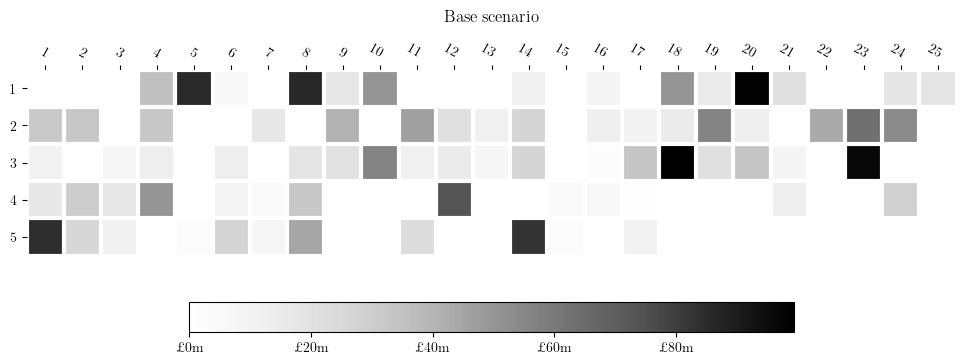

In [9]:
(price, demand, capacity, share, 
 supplier_transfer_limit, min_units, 
 trust) = generate_supplier_selector_variables(n_suppliers=5, 
                                               n_parts=25,
                                               n_years=10,
                                               print_data=False,
                                               seed_value=2);

base_scenario = SupplierSelectionModel(price, 
                                       demand, 
                                       capacity=capacity, 
                                       supplier_transfer_limit=supplier_transfer_limit, 
                                       share=share,
                                       global_transfer_limit=1,
                                       minimum_units=min_units,
                                       trust=trust)

base_scenario.minimise_cost()
base_scenario.plot_heatmap(name="Base scenario")


## Buying strategies and questions

**Scenario A**: What would happen if Supplier 3 reduced all their prices by 10%? How much additional work would Supplier 3 win?

**Scenario B**: What would happen if we trusted all suppliers? We can improve trust in a supplier by embedding Rolls-Royce employees in the supplier factory

**Scenario C**: what would happen if there are no constraints?

In [10]:
reduced_price = compute_reduced_price(price, 2, 0.1)
scenario_a = SupplierSelectionModel(reduced_price,
                                    demand, 
                                    capacity=capacity, 
                                    supplier_transfer_limit=supplier_transfer_limit, 
                                    share=share,
                                    global_transfer_limit=1,
                                    minimum_units=min_units,
                                    trust=trust)

scenario_b = SupplierSelectionModel(price, 
                                    demand, 
                                    capacity=capacity, 
                                    supplier_transfer_limit=supplier_transfer_limit, 
                                    share=share,
                                    global_transfer_limit=1,
                                    minimum_units=min_units,
                                    trust=None)

scenario_c = SupplierSelectionModel(price, 
                                    demand, 
                                    capacity=None, 
                                    supplier_transfer_limit=None, 
                                    share=None,
                                    global_transfer_limit=None,
                                    minimum_units=None,
                                    trust=None)

Execution time: 0.14435 seconds
Execution time: 0.12158 seconds
Execution time: 0.07421 seconds


## Scenario A - Supplier 3 reduces all quoted prices by 10%

Supplier 3 would realise a greater than 100% increase in work won if they reduce all quoted prices by 10%

| Scenario | Supplier 3 work won | 
| -------- | ----------- |
| Base | £492.67 million |
| Scenario A | £995.04 million |

The total cost is reduced from **£2,149,881,615** to **£2,043,923,624** - a saving of **£106 million**

In [11]:
scenario_a.minimise_cost()


Optimal solution found: cost - £2,043,923,624.00
Execution time: 2.21312 seconds


In [12]:
base_scenario.print_work_value()


Supplier  1: £      521.42 m

Supplier  2: £      526.98 m

Supplier  3: £      492.67 m

Supplier  4: £      285.95 m

Supplier  5: £      322.87 m


In [13]:
scenario_a.print_work_value()


Supplier  1: £      339.08 m

Supplier  2: £      347.17 m

Supplier  3: £      995.04 m

Supplier  4: £      163.72 m

Supplier  5: £      198.90 m


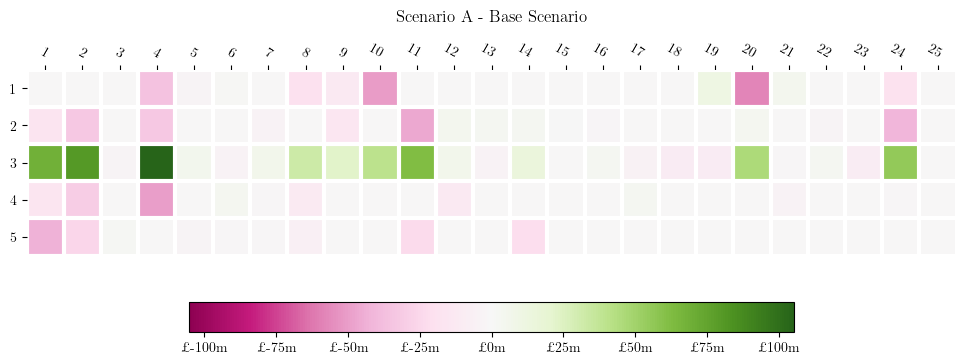

In [14]:
scenario_a.heatmap_difference(base_scenario, name="Scenario A - Base Scenario")

## Scenario B - all suppliers are trusted

The total cost is reduced from **£2,149,881,615** to **£2,147,576,451** - a saving of **£2.3 million**

This information is really valuable as we can now answer the following question objectively - is it cost effective to embed Rolls-Royce employees in the supplier factory to improve trust?


Optimal solution found: cost - £2,147,576,451.00
Execution time: 2.53902 seconds


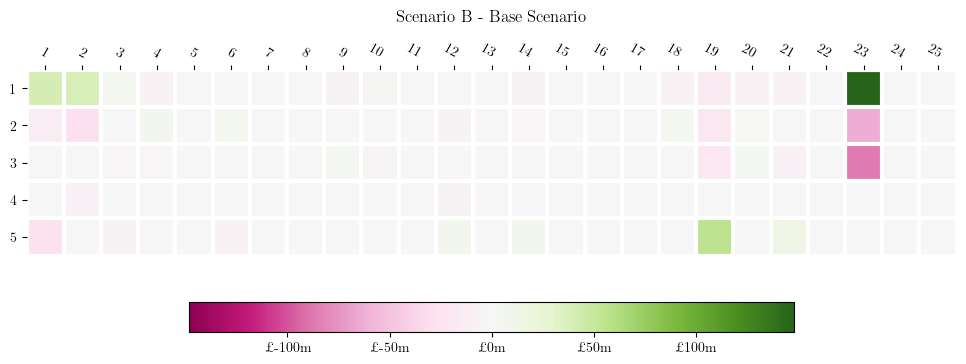

In [15]:
scenario_b.minimise_cost()
scenario_b.heatmap_difference(base_scenario, name="Scenario B - Base Scenario")

## Scenario C - no constraints

The total cost is reduced from **£2,149,881,615** to **£2,142,694,436** - a saving of **£7.2 million**


Optimal solution found: cost - £2,142,694,436.00
Execution time: 0.03908 seconds


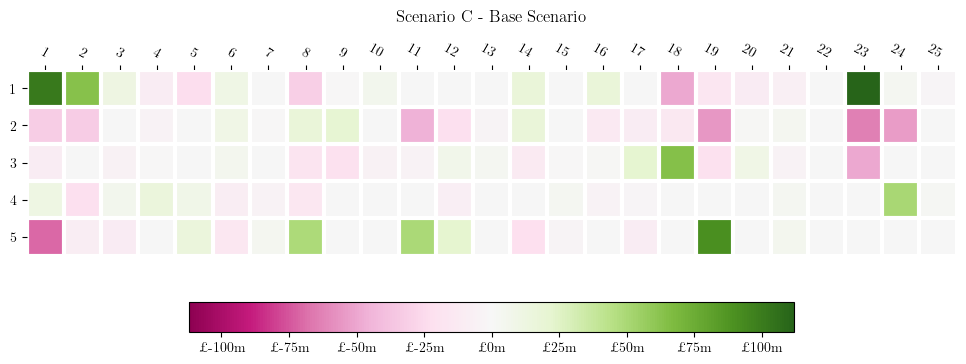

In [16]:
scenario_c.minimise_cost()
scenario_c.heatmap_difference(base_scenario, name="Scenario C - Base Scenario")

---

# Additional factors to consider

In all the above examples, the objective is to minimise cost. However, many other factors must be considered when awarding manufacturing contracts. 

### Minimise 

- $\textrm{CO}_2$ emissions
- Transport distance

### Maximise 

- Trust (an uncertain metric that represents confidence in a supplier)
- Environmental, Social and Governance (ESG) metrics

---

# Similar problems

## Optimising product promotion budget allocation

- A client (think Unilever) needs to optimise the allocation of their nearly multi billion dollar budget to promote over 5,000 brand and account combinations to reach target growth objectives for account-brand combinations
- Automating the allocation of trade spend will reduce applied time and resources, allow scenarios to be planned and quickly tested to inform the optimal marketing mix, and provide a scalable foundation to optimise trade and marketing spend across retail channels, customers, and product lines

